Nama      : Ilham Padli <br>
NIM       : 09011181823125 <br>
Kelas     : SK5A Indralaya <br>

<h1>Persiapan Library Yang Diperlukan<h1>

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h1>Persiapan Dataset Yang Diperlukan<h1>

In [36]:
hour_data_source = 'Data/Data2_Hour.csv'
rides_hour       = pd.read_csv(hour_data_source)

In [37]:
rides_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Dataset ini memiliki jumlah pengendara untuk setiap jam, setiap hari dari 1 Januari 2011 hingga 31 Desember 2012. Jumlah pengendara dibagi antara biasa dan terdaftar, dijumlahkan di kolom cnt. Ini dapat dilihat dari beberapa baris pertama dari data di atas.

Data untuk 10 hari pertama dapat dilihat dibawah :

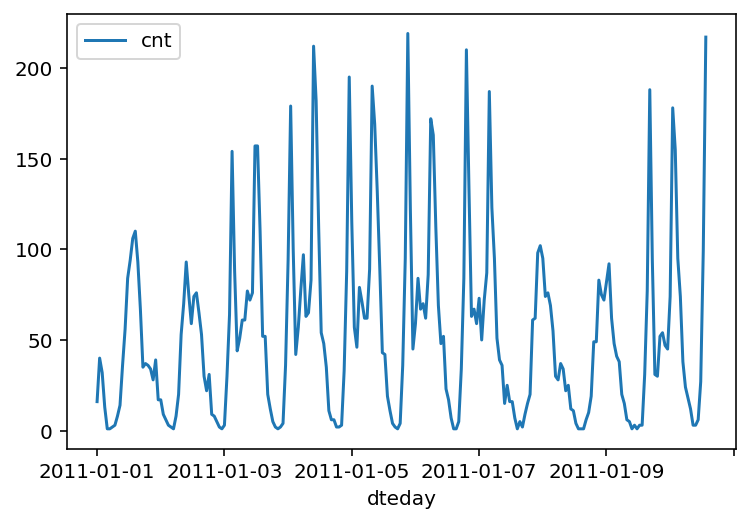

In [38]:
rides_hour[:24*10].plot(x='dteday', y='cnt')

Dataset ini memiliki beberapa variabel kategori seperti musim, cuaca, bulan. Untuk memasukkan ini ke dalam model kita, kita perlu membuat variabel dummy biner. Ini mudah dilakukan dengan Panda berkat fungsi get_dummies() yang tersedia.

In [39]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies    = pd.get_dummies(rides_hour[each], prefix=each, drop_first=False)
    rides_hour = pd.concat([rides_hour, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides_hour.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


Untuk membuat training jaringan lebih mudah, kami akan menstandarkan setiap variabel kontinu. Artinya, kita akan menggeser dan menskalakan variabel sedemikian rupa sehingga variabel tersebut memiliki mean nol dan deviasi standar 1.

Faktor penskalaan disimpan sehingga kita dapat mundur saat menggunakan jaringan untuk prediksi.

In [40]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Menyimpan skala dalam variabel dictionary agar digunakan kembali
scaled_features = {}
for each in quant_features:
    mean, std             = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each]     = (data[each] - mean)/std

<h1>Memisahkan data menjadi set pelatihan, pengujian, dan validasi</h1>
<p>Selama sekitar 21 hari terakhir data akan disimpan untuk digunakan sebagai set pengujian setelah mentraining jaringan.Set ini digunakan untuk membuat prediksi dan membandingkannya dengan jumlah pengendara sebenarnya.</p>

In [41]:
# Simpan data dalam 21 hari terakhir
test_data = data[-21*24:]

# Menghapus data test dari data asli
data = data[:-21*24]

# Memisahkan data menjadi fitur dan target
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

<p>Data akan dibagi menjadi dua set, satu untuk pelatihan dan satu lagi untuk memvalidasi saat jaringan sedang dilatih. Karena ini adalah data deret waktu, maka akan pelatihan data historis, kemudian mencoba memprediksi data masa depan (set validasi).</p>

In [42]:
# Simpan data 60 hari terakhir atau lebih dari data yang tersisa sebagai set validasi
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]


<h1>Skema Network</h1>
<p>Dibawah ini akan dibangun model network yang sesuai dengan data yang akan diuji</p>
<img src="Data/Neural_Network_Model.png" style="max-width:25%">
<p>Jaringan memiliki dua layer, hidden layer dan output layer. Hidden layer akan menggunakan <b>fungsi sigmoid</b> untuk aktivasi. Output layer hanya memiliki satu node dan digunakan untuk regresi, output node sama dengan input node. Artinya, fungsi aktivasi adalah <b>𝑓 (𝑥) = 𝑥</b>. Suatu fungsi yang menerima sinyal masukan dan menghasilkan sinyal keluaran, tetapi memperhitungkan ambang batas, disebut fungsi aktivasi. Hal ini bekerja melalui setiap layer jaringan untuk menghitung keluaran untuk setiap neuron. Semua keluaran dari satu lapisan menjadi masukan ke neuron di lapisan berikutnya. Proses ini disebut <b>propagasi maju</b>.</p>

In [43]:
from PythonSource import NeuralNetwork
def MSE(y, Y):
    return np.mean((y-Y)**2)

<h1>Unit Test</h1>
<p>Pengujian unit ini untuk memeriksa kebenaran implementasi jaringan. Ini akan membantu untuk memastikan jaringan diterapkan dengan benar sebelum mulai mencoba melatihnya.</p>

In [44]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    def test_data_path(self):
        self.assertTrue(hour_data_source.lower() == 'data/data2_hour.csv')
        
    def test_data_loaded(self):
        self.assertTrue(isinstance(rides_hour, pd.DataFrame))
    
    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):

        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):

        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

<h1>Melatih jaringan</h1>
<p>Di sini akan diatur hyperparameter untuk jaringan. Strateginya di sini adalah menemukan hyperparameter sedemikian rupa sehingga kesalahan pada set pelatihan rendah, tetapi Anda tidak overfitting ke data. Jika melatih jaringan terlalu lama atau memiliki terlalu banyak node tersembunyi, ini bisa menjadi terlalu spesifik untuk set pelatihan dan akan gagal untuk menggeneralisasi set validasi. Artinya, kerugian pada set validasi akan mulai meningkat saat kerugian set pelatihan turun.</p>

Dalam uji coba ini juga akan menggunakan metode yang dikenal sebagai <b>Stochastic Gradient Descent (SGD)</b> untuk melatih jaringan. Idenya adalah bahwa untuk setiap tiket pelatihan, Akan mengambil sampel data secara acak alih-alih menggunakan seluruh kumpulan data. Dan juga menggunakan lebih banyak operan pelatihan dibandingkan dengan penurunan gradien normal, tetapi setiap operan jauh lebih cepat. Ini akhirnya melatih jaringan dengan lebih efisien.


In [45]:
import sys

from PythonSource import iterations, learning_rate, hidden_nodes, output_nodes


N_i     = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses  = {'train':[], 'validation':[]}
for ii in range(iterations):

    batch = np.random.choice(train_features.index, size=128)
    X, y  = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss   = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.060 ... Validation loss: 0.152

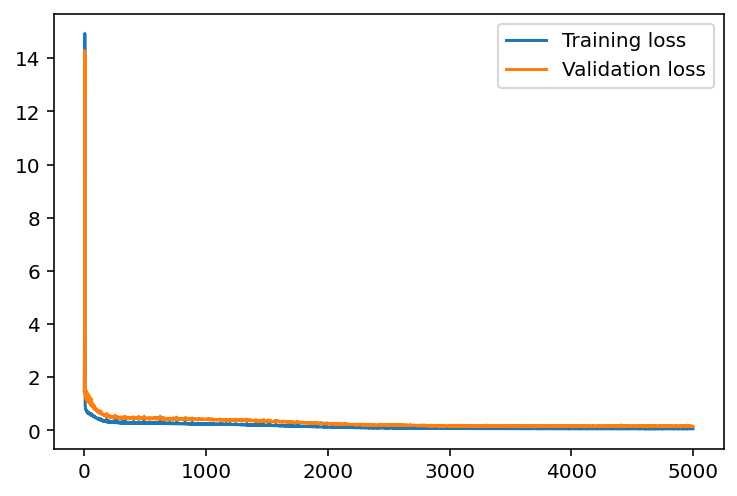

In [46]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

<h1>Prediksi</h1>
Di sini, gunakan data pengujian untuk melihat seberapa baik jaringan memodelkan data. 

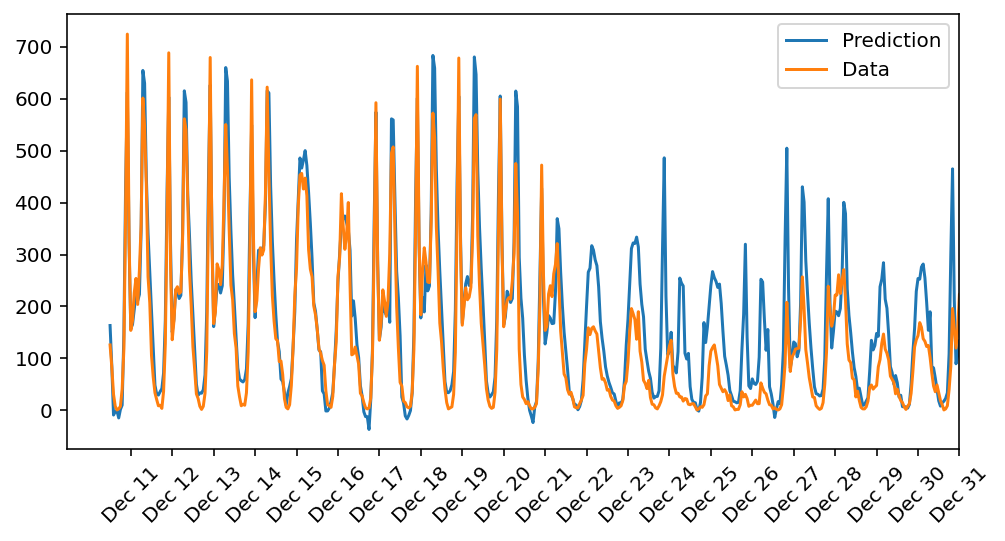

In [48]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

<h1>Kesimpulan</h1>
Jika dilihat dari data yang ada, maka prediksi yang didapat tidak sepenuhnya presesi. Ini dapat dilihat dari data pada tanggal 22 Desember sampai 31 mengalami prediksi yang jauh dari data yang ada.